# *Future Frame Prediction for Anomaly Detection – A New Baseline*

### Test the pre-trained model on several datasets

In [1]:
import tensorflow as tf
import os
import time
import numpy as np
import pickle


from models import generator
from utils import DataLoader, load, save, psnr_error
from constant import const
import evaluate

usage: ipykernel_launcher.py [-h] [-g GPU] [-i ITERS] [-b BATCH]
                             [--num_his NUM_HIS] [-d DATASET]
                             [--train_folder TRAIN_FOLDER]
                             [--test_folder TEST_FOLDER] [--config CONFIG]
                             [--snapshot_dir SNAPSHOT_DIR]
                             [--summary_dir SUMMARY_DIR] [--psnr_dir PSNR_DIR]
                             [--evaluate EVALUATE]
ipykernel_launcher.py: error: unrecognized arguments: -f /run/user/1004/jupyter/kernel-ce2f9280-548d-416c-bf91-977db3850625.json


SystemExit: 2

/home/brianyao/Envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
slim = tf.contrib.slim

os.environ['CUDA_DEVICES_ORDER'] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = const.GPU

dataset_name = const.DATASET
test_folder = const.TEST_FOLDER

num_his = const.NUM_HIS
height, width = 256, 256

snapshot_dir = const.SNAPSHOT_DIR
psnr_dir = const.PSNR_DIR
evaluate_name = const.EVALUATE

In [3]:
# define dataset
with tf.name_scope('dataset'):
    test_video_clips_tensor = tf.placeholder(shape=[1, height, width, 3 * (num_his + 1)],
                                             dtype=tf.float32)
    test_inputs = test_video_clips_tensor[..., 0:num_his*3]
    test_gt = test_video_clips_tensor[..., -3:]
    print('test inputs = {}'.format(test_inputs))
    print('test prediction gt = {}'.format(test_gt))

test inputs = Tensor("dataset/strided_slice:0", shape=(1, 256, 256, 12), dtype=float32)
test prediction gt = Tensor("dataset/strided_slice_1:0", shape=(1, 256, 256, 3), dtype=float32)


In [4]:
# define testing generator function and
# in testing, only generator networks, there is no discriminator networks and flownet.
with tf.variable_scope('generator', reuse=None):
    print('testing = {}'.format(tf.get_variable_scope().name))
    test_outputs = generator(test_inputs, layers=4, output_channel=3)
    test_psnr_error = psnr_error(gen_frames=test_outputs, gt_frames=test_gt)


config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    # dataset
    data_loader = DataLoader(test_folder, height, width)

    # initialize weights
    sess.run(tf.global_variables_initializer())
    print('Init global successfully!')

    # tf saver
    saver = tf.train.Saver(var_list=tf.global_variables(), max_to_keep=None)

    restore_var = [v for v in tf.global_variables()]
    loader = tf.train.Saver(var_list=restore_var)

    def inference_func(ckpt, dataset_name, evaluate_name):
        load(loader, sess, ckpt)
        
        psnr_records = []
        videos_info = data_loader.videos
        num_videos = len(videos_info.keys())
        total = 0
        timestamp = time.time()

        for video_name, video in videos_info.items():
            length = video['length']
            total += length
            psnrs = np.empty(shape=(length,), dtype=np.float32)

            for i in range(num_his, length):
                video_clip = data_loader.get_video_clips(video_name, i - num_his, i + 1)
                psnr = sess.run(test_psnr_error,
                                feed_dict={test_video_clips_tensor: video_clip[np.newaxis, ...]})
                psnrs[i] = psnr

                print('video = {} / {}, i = {} / {}, psnr = {:.6f}'.format(
                    video_name, num_videos, i, length, psnr))

            psnrs[0:num_his] = psnrs[num_his]
            psnr_records.append(psnrs)

        result_dict = {'dataset': dataset_name, 'psnr': psnr_records, 'flow': [], 'names': [], 'diff_mask': []}

        used_time = time.time() - timestamp
        print('total time = {}, fps = {}'.format(used_time, total / used_time))

        # TODO specify what's the actual name of ckpt.
        pickle_path = os.path.join(psnr_dir, os.path.split(ckpt)[-1])
        with open(pickle_path, 'wb') as writer:
            pickle.dump(result_dict, writer, pickle.HIGHEST_PROTOCOL)

        results = evaluate.evaluate(evaluate_name, pickle_path)
        print(results)


    if os.path.isdir(snapshot_dir):
        def check_ckpt_valid(ckpt_name):
            is_valid = False
            ckpt = ''
            if ckpt_name.startswith('model.ckpt-'):
                ckpt_name_splits = ckpt_name.split('.')
                ckpt = str(ckpt_name_splits[0]) + '.' + str(ckpt_name_splits[1])
                ckpt_path = os.path.join(snapshot_dir, ckpt)
                if os.path.exists(ckpt_path + '.index') and os.path.exists(ckpt_path + '.meta') and \
                        os.path.exists(ckpt_path + '.data-00000-of-00001'):
                    is_valid = True

            return is_valid, ckpt

        def scan_psnr_folder():
            tested_ckpt_in_psnr_sets = set()
            for test_psnr in os.listdir(psnr_dir):
                tested_ckpt_in_psnr_sets.add(test_psnr)
            return tested_ckpt_in_psnr_sets

        def scan_model_folder():
            saved_models = set()
            for ckpt_name in os.listdir(snapshot_dir):
                is_valid, ckpt = check_ckpt_valid(ckpt_name)
                if is_valid:
                    saved_models.add(ckpt)
            return saved_models

        tested_ckpt_sets = scan_psnr_folder()
        while True:
            all_model_ckpts = scan_model_folder()
            new_model_ckpts = all_model_ckpts - tested_ckpt_sets
            if len(new_model_ckpts) == 0:
                break
            for ckpt_name in new_model_ckpts:
                # inference
                ckpt = os.path.join(snapshot_dir, ckpt_name)
                inference_func(ckpt, dataset_name, evaluate_name)

                tested_ckpt_sets.add(ckpt_name)

            print('waiting for models...')
            evaluate.evaluate('compute_auc', psnr_dir)
            time.sleep(60)
    else:
        inference_func(snapshot_dir, dataset_name, evaluate_name)

testing = generator
Init global successfully!


# Visualize prediction module output

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
ckpt_name = 'model.ckpt-1000'
ckpt = os.path.join(snapshot_dir, ckpt_name)
video_name = '000489'
i = 50
with tf.Session(config=config) as sess:
    load(loader, sess, ckpt)
    video_clip = data_loader.get_video_clips(video_name, i - num_his, i + 1) # video clip size is (W,H,(4+1)*3)
    pred_frame = sess.run(test_outputs,
                        feed_dict={test_video_clips_tensor: video_clip[np.newaxis, ...]})
    gt_frame = video_clip[:,:,-3:]

INFO:tensorflow:Restoring parameters from checkpoints/taiwan_sa_l_2_alpha_1_lp_1.0_adv_0.05_gdl_1.0_flow_2.0/model.ckpt-1000
Restored model parameters from checkpoints/taiwan_sa_l_2_alpha_1_lp_1.0_adv_0.05_gdl_1.0_flow_2.0/model.ckpt-1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


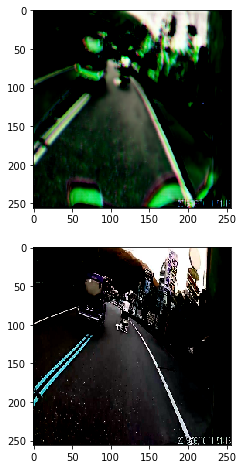

In [29]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 8), nrows=2, ncols=1)
ax1.imshow(pred_frame[0])
ax2.imshow(gt_frame)

In [ ]:
plt.imshow(video_clip[:,:,:3])